In [1]:
##### CS480 Project #####
# Harmony generator 
# Lang Su
# 20630791
# l26su@edu.uwaterloo.ca

In [2]:
# library dependency 
import numpy as np
import pandas as pd
import os
from music21 import *
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [3]:
# return the first note in a music chord object
def get_first_note_from_chord(chord):
    note_lst = [str(n) for n in chord.pitches]
    return note_lst[0]

# takes a path of a midi file, return a list that contains 2 lists of strings
# The first list is melody, the second is harmony
# These lists contains strings of pitch name
# e,g, [C3, A#, *, D3]
# * is a customized char, stand for a rest
def midi_to_note(path):
    piece = converter.parse(path)
    
    if len(piece.parts) != 2:
        print("Not valid for training: {}".format(path))
        return None
    #print(piece.parts[0].__dict__)

    track_list = []
    
    # for each track in the midi file
    for part in piece.parts:
        
        note_to_parse = part.recurse() 

        track = []

        for element in note_to_parse:
            # For note: We use pitch's string expression
            if isinstance(element, note.Note):
                track.append(str(element.pitch))

            # For chord: We take the first note in the chord 
            elif isinstance(element, chord.Chord):
                track.append(get_first_note_from_chord(element))
                
            # For Rest: A rest is a note with no pitch of time length 1.0
            # We express it using a *
            elif isinstance(element, note.Rest):
                track.append("*")
            
        track_list.append(track)

    return track_list

In [4]:
from sklearn.model_selection import train_test_split

# take a path string to the directory of midi files
# return input_streams: melody list for each song
#        output_streams: harmony list for each song
#        max_input_seq_num: the longest length of melody in input stream
#        max_output_seq_num: the longest length of harmony in output stream
def get_input(path_to_dir):
    input_streams = [] # right hand
    output_streams = [] # left hand
    max_input_seq_num = 0
    max_output_seq_num = 0
    counter = 0
    for file in os.listdir(path_to_dir):
        if file.endswith(".mid"):
            full_path = os.path.join(path_to_dir, file)
            result = midi_to_note(full_path)
            if result!=None: # if qualified 2 track midi
                input_streams.append(result[0])
                output_streams.append(result[1])
                counter += 1 

    # decide which stream has the longest length
    max_input_seq_num = max(len(input_stream) for input_stream in input_streams)
    max_output_seq_num = max(len(output_stream) for output_stream in output_streams)
    
    print("Finished {} of midi files. Max input stream length {}, max output stream length {}"\
          .format(str(counter), str(max_input_seq_num), str(max_output_seq_num)))
    
    return input_streams, output_streams, max_input_seq_num, max_output_seq_num

total_input_streams, total_output_streams, max_input_seq_num, max_output_seq_num \
= get_input("./dataset/")
train_input_streams, test_input_streams, train_output_streams, test_output_streams \
= train_test_split(total_input_streams, total_output_streams, test_size=0.1, random_state=42)
print(len(train_input_streams))
print(len(train_output_streams))
print(len(test_input_streams))
print(len(test_output_streams))

Not valid for training: ./dataset/6c29793a140a811d0c45ce03c1c93a28.mid
Not valid for training: ./dataset/07c5807d0d927dcd0980f86024e5208b.mid
Not valid for training: ./dataset/92bbd31f8e0e43a7da8a6295b251725f.mid
Not valid for training: ./dataset/5b69b9cb83065d403869739ae7f0995e.mid
Not valid for training: ./dataset/d3a7f48c12e697d50c8a7ae7684644ef.mid
Not valid for training: ./dataset/298f587406c914fad5373bb689300433.mid
Finished 114 of midi files. Max input stream length 368, max output stream length 343
102
102
12
12


Found 79 keys used in all midi files


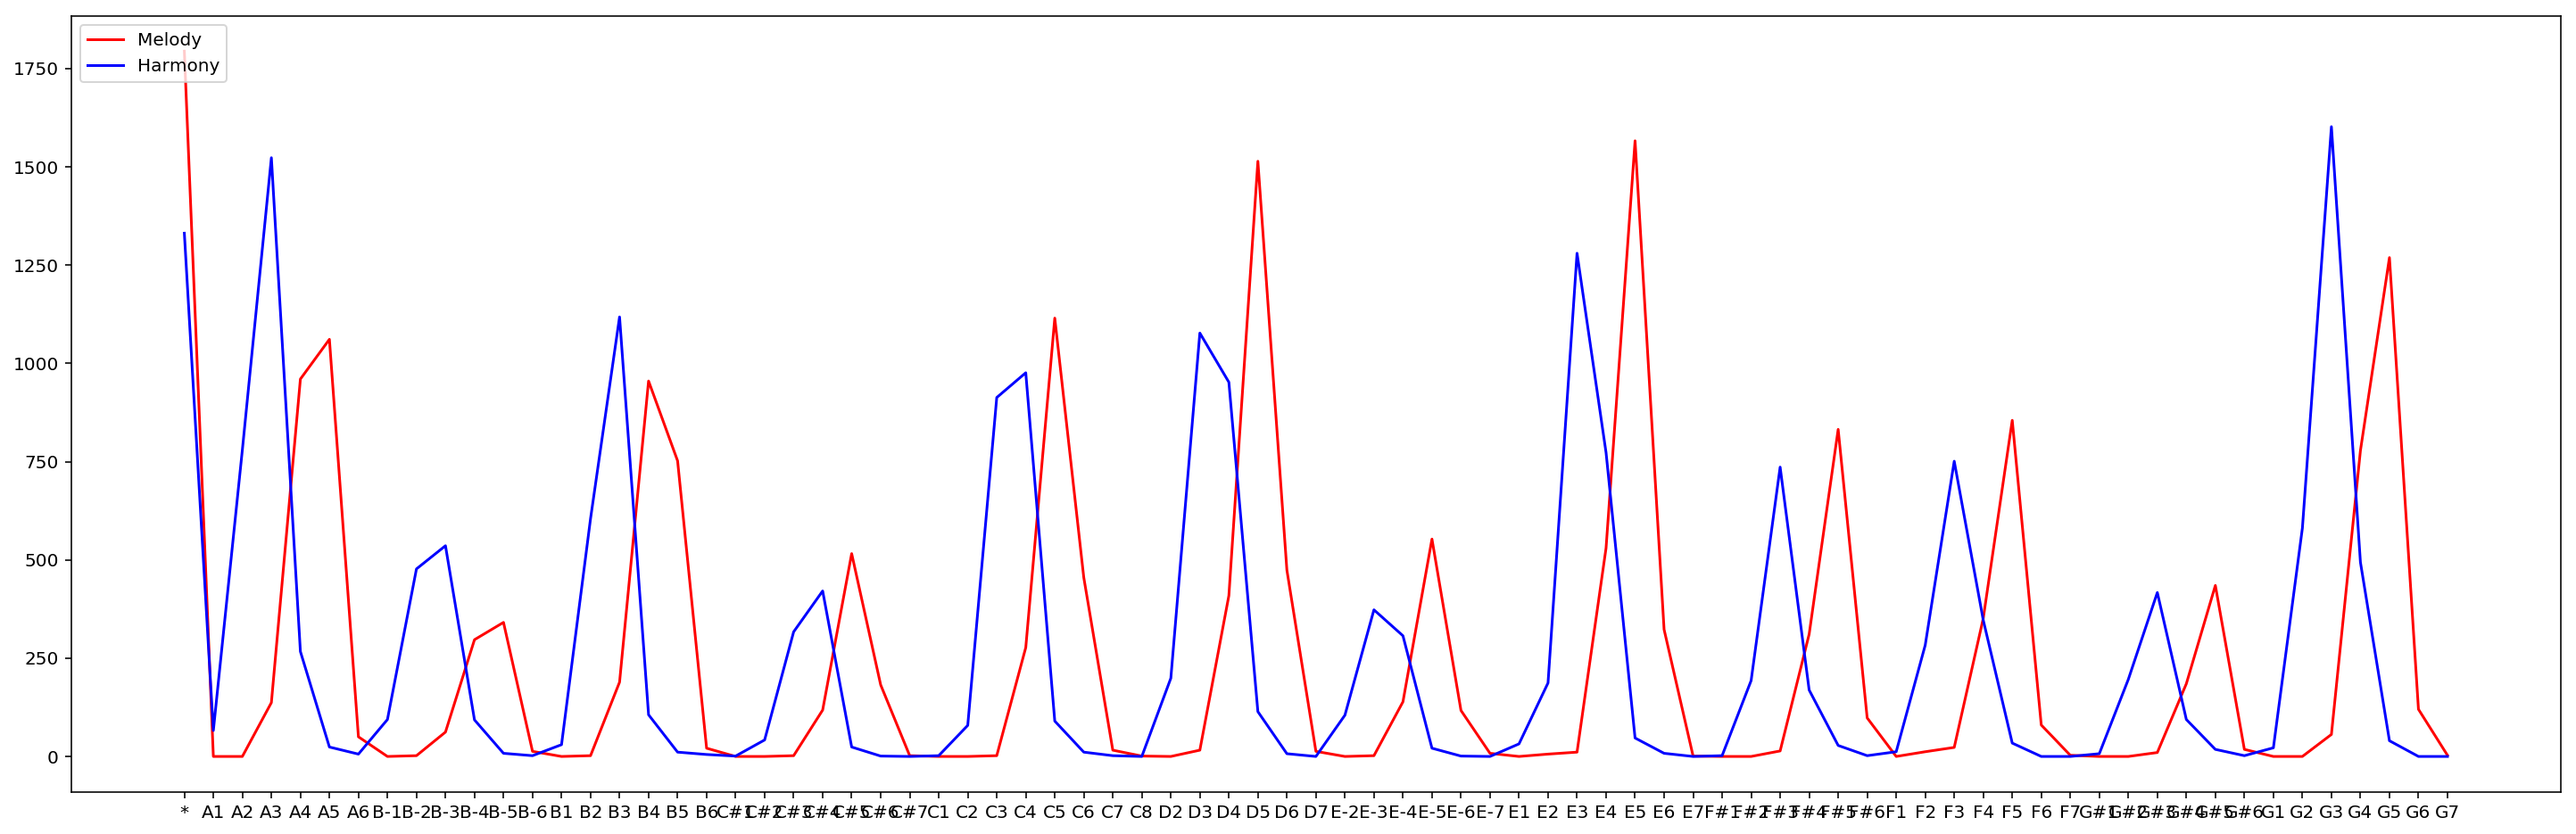

In [5]:
# get key set in the input stream. 
# Like get all characters set from an article 
import copy
import matplotlib.pyplot as plt

def get_all_keys(input_streams, output_streams):
    all_keys = [] # dot is also consider a "character" that shape our chord string
    input_all_freq = []
    output_all_freq = []
    for song in input_streams:
        for s in song:
            if s not in all_keys:
                all_keys.append(s)
                input_all_freq.append(1)
            else:
                idx = all_keys.index(s)
                input_all_freq[idx] += 1

    output_all_freq = [0] * len(input_all_freq)
    
    for song in output_streams:
        for s in song:
            if s not in all_keys:
                all_keys.append(s)
                output_all_freq.append(1)
            else:
                idx = all_keys.index(s)
                output_all_freq[idx] += 1

    input_all_freq = input_all_freq + [0] * (len(output_all_freq)-len(input_all_freq))
                
    return all_keys, input_all_freq, output_all_freq

            
all_keys, in_freq, out_freq = get_all_keys(train_input_streams, train_output_streams)
in_freq = [x for _,x in sorted(zip(copy.deepcopy(all_keys),copy.deepcopy(in_freq)))]
out_freq = [x for _,x in sorted(zip(copy.deepcopy(all_keys),copy.deepcopy(out_freq)))]
all_keys = sorted(all_keys)

key_idx_pair = dict([(char, i) for i, char in enumerate(all_keys)])

plt.figure(figsize=(25,8))
plt.plot(all_keys, in_freq, 'r', label="Melody")
plt.plot(all_keys, out_freq, 'b', label="Harmony")
plt.legend(loc='upper left')

print("Found {} keys used in all midi files".format(str(len(all_keys))))

In [6]:
# onehot encode encoder input data, decoder input data and decoder target data
# to feed in model
def onehot_encode(input_streams, output_streams, max_input_seq_num, max_output_seq_num, all_keys):
    encoder_input_data = np.zeros(
        (len(input_streams), max_input_seq_num, len(all_keys)))
    decoder_input_data = np.zeros(
        (len(output_streams), max_output_seq_num, len(all_keys)))
    decoder_target_data = np.zeros(
        (len(output_streams), max_output_seq_num, len(all_keys)))

    print(encoder_input_data.shape)
    print(decoder_input_data.shape)

    for i, (input_stream, output_stream) in enumerate(zip(input_streams, output_streams)):
        for t, char in enumerate(input_stream):
            encoder_input_data[i, t, key_idx_pair.get(char)] = 1.
        for t, char in enumerate(output_stream):
            # decoder_target_data is ahead of decoder_input_data by one timestep
            decoder_input_data[i, t, key_idx_pair.get(char)] = 1.
            if t > 0:
                # decoder_target_data will be ahead by one timestep
                # and will not include the start character.
                decoder_target_data[i, t - 1, key_idx_pair.get(char)] = 1.
    return encoder_input_data, decoder_input_data, decoder_target_data

train_encoder_input_data, train_decoder_input_data, train_decoder_target_data \
= onehot_encode(train_input_streams, train_output_streams, max_input_seq_num, max_output_seq_num, all_keys)

test_encoder_input_data, test_decoder_input_data, test_decoder_target_data \
= onehot_encode(test_input_streams, test_output_streams, max_input_seq_num, max_output_seq_num, all_keys)


(102, 368, 79)
(102, 343, 79)
(12, 368, 79)
(12, 343, 79)


In [17]:
# compile encoder-decoder model and train using the given parameters
# cont is a important parameter: 
# if cont is True: it will read the output_file_name from the weight folder and continue training 
# that weight file instead of overwrite 
def compile_and_train(batch_size, epochs, latent_dim, num_samples, output_file_name, cont=False):
    # encoder model
    # input
    encoder_inputs = Input(shape=(None, len(all_keys)))
    encoder = LSTM(latent_dim, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    # Encoder States
    encoder_states = [state_h, state_c]

    # decoder model
    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    # input
    decoder_inputs = Input(shape=(None, len(all_keys)))
    decoder = LSTM(latent_dim, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder(decoder_inputs, initial_state=encoder_states)
    # Activation Layer
    decoder_dense = Dense(len(all_keys), activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    # Run training
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

    if cont:# continue training
        model.load_weights(output_file_name)

    filepath = output_file_name    
    checkpoint = ModelCheckpoint(
        filepath, monitor='loss', 
        verbose=1,        
        save_best_only=True,        
        mode='min'
    )    
    callbacks_list = [checkpoint]     

    model.fit([train_encoder_input_data, train_decoder_input_data], train_decoder_target_data,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_split=0.1,
              callbacks=callbacks_list)
    # Save model
    model.save(output_file_name)

    train_loss = model.history.history['loss']
    val_loss = model.history.history['val_loss']
    tot_epoch = model.history.epoch
    config_detail = [batch_size, epochs, latent_dim, num_samples]
    
    total_history.append([config_detail, train_loss, val_loss, tot_epoch])

    
total_history = []

num_samples = len(train_input_streams)  # Number of samples to train on.
epochs = 60  # Number of epochs to train for.
# in the report it's [1, 8, 16]
batch_sizes = [1, 8, 16] 
# in the report it's [64, 128, 256]
latent_dims = [64, 128, 256]  # Latent dimensionality of the encoding space.

# The code here run every combination in the batch sizes list and latent dims list
# When epochs = 60, only 1 batch size is able to generate good music
# Change these parameters according to your need
for batch_size in batch_sizes:
    for latent_dim in latent_dims:
        output_file_name = "./weights_epoch_120/batch_{}_latent_{}_.h5".format(str(batch_size), str(latent_dim))
        compile_and_train(batch_size, epochs, latent_dim, num_samples, output_file_name, True)

Train on 91 samples, validate on 11 samples
Epoch 1/60
91/91 [==============================] - 54s 593ms/step - loss: 1.3532 - val_loss: 1.4551

Epoch 00001: loss improved from inf to 1.35320, saving model to ./weights_epoch_120/batch_1_latent_64_.h5


/Users/kevinsu/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:877: UserWarning: Layer lstm_24 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_23/while/Exit_2:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'lstm_23/while/Exit_3:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/60
91/91 [==============================] - 51s 566ms/step - loss: 1.3402 - val_loss: 1.4426

Epoch 00002: loss improved from 1.35320 to 1.34025, saving model to ./weights_epoch_120/batch_1_latent_64_.h5
Epoch 3/60
91/91 [==============================] - 50s 548ms/step - loss: 1.3332 - val_loss: 1.4476

Epoch 00003: loss improved from 1.34025 to 1.33317, saving model to ./weights_epoch_120/batch_1_latent_64_.h5
Epoch 4/60
91/91 [==============================] - 51s 556ms/step - loss: 1.3249 - val_loss: 1.4471

Epoch 00004: loss improved from 1.33317 to 1.32488, saving model to ./weights_epoch_120/batch_1_latent_64_.h5
Epoch 5/60
91/91 [==============================] - 50s 547ms/step - loss: 1.3238 - val_loss: 1.4794

Epoch 00005: loss improved from 1.32488 to 1.32377, saving model to ./weights_epoch_120/batch_1_latent_64_.h5
Epoch 6/60
91/91 [==============================] - 50s 546ms/step - loss: 1.3161 - val_loss: 1.4346

Epoch 00006: loss improved from 1.32377 to 1.31607

91/91 [==============================] - 50s 550ms/step - loss: 1.1450 - val_loss: 1.5569

Epoch 00042: loss did not improve from 1.14418
Epoch 43/60
91/91 [==============================] - 50s 550ms/step - loss: 1.1396 - val_loss: 1.5669

Epoch 00043: loss improved from 1.14418 to 1.13960, saving model to ./weights_epoch_120/batch_1_latent_64_.h5
Epoch 44/60
91/91 [==============================] - 50s 545ms/step - loss: 1.1326 - val_loss: 1.5614

Epoch 00044: loss improved from 1.13960 to 1.13263, saving model to ./weights_epoch_120/batch_1_latent_64_.h5
Epoch 45/60
91/91 [==============================] - 50s 546ms/step - loss: 1.1280 - val_loss: 1.5748

Epoch 00045: loss improved from 1.13263 to 1.12805, saving model to ./weights_epoch_120/batch_1_latent_64_.h5
Epoch 46/60
91/91 [==============================] - 50s 552ms/step - loss: 1.1266 - val_loss: 1.5651

Epoch 00046: loss improved from 1.12805 to 1.12656, saving model to ./weights_epoch_120/batch_1_latent_64_.h5
Epoch 47/6

/Users/kevinsu/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:877: UserWarning: Layer lstm_26 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_25/while/Exit_2:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'lstm_25/while/Exit_3:0' shape=(?, 128) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/60
91/91 [==============================] - 50s 549ms/step - loss: 1.0673 - val_loss: 1.5237

Epoch 00002: loss improved from 1.09329 to 1.06734, saving model to ./weights_epoch_120/batch_1_latent_128_.h5
Epoch 3/60
91/91 [==============================] - 50s 545ms/step - loss: 1.0541 - val_loss: 1.5655

Epoch 00003: loss improved from 1.06734 to 1.05414, saving model to ./weights_epoch_120/batch_1_latent_128_.h5
Epoch 4/60
91/91 [==============================] - 50s 548ms/step - loss: 1.0420 - val_loss: 1.5584

Epoch 00004: loss improved from 1.05414 to 1.04199, saving model to ./weights_epoch_120/batch_1_latent_128_.h5
Epoch 5/60
91/91 [==============================] - 50s 547ms/step - loss: 1.0323 - val_loss: 1.5749

Epoch 00005: loss improved from 1.04199 to 1.03230, saving model to ./weights_epoch_120/batch_1_latent_128_.h5
Epoch 6/60
91/91 [==============================] - 50s 549ms/step - loss: 1.0262 - val_loss: 1.5758

Epoch 00006: loss improved from 1.03230 to 1.0

91/91 [==============================] - 50s 546ms/step - loss: 0.6985 - val_loss: 1.8590

Epoch 00041: loss improved from 0.71025 to 0.69853, saving model to ./weights_epoch_120/batch_1_latent_128_.h5
Epoch 42/60
91/91 [==============================] - 50s 547ms/step - loss: 0.6952 - val_loss: 1.8951

Epoch 00042: loss improved from 0.69853 to 0.69524, saving model to ./weights_epoch_120/batch_1_latent_128_.h5
Epoch 43/60
91/91 [==============================] - 50s 546ms/step - loss: 0.6825 - val_loss: 1.8828

Epoch 00043: loss improved from 0.69524 to 0.68245, saving model to ./weights_epoch_120/batch_1_latent_128_.h5
Epoch 44/60
91/91 [==============================] - 50s 547ms/step - loss: 0.6718 - val_loss: 1.9165

Epoch 00044: loss improved from 0.68245 to 0.67185, saving model to ./weights_epoch_120/batch_1_latent_128_.h5
Epoch 45/60
91/91 [==============================] - 50s 546ms/step - loss: 0.6703 - val_loss: 1.9284

Epoch 00045: loss improved from 0.67185 to 0.67035, s

/Users/kevinsu/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:877: UserWarning: Layer lstm_28 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_27/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_27/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/60
91/91 [==============================] - 53s 578ms/step - loss: 0.5459 - val_loss: 1.9160

Epoch 00002: loss improved from 0.58558 to 0.54585, saving model to ./weights_epoch_120/batch_1_latent_256_.h5
Epoch 3/60
91/91 [==============================] - 52s 576ms/step - loss: 0.5253 - val_loss: 1.9181

Epoch 00003: loss improved from 0.54585 to 0.52527, saving model to ./weights_epoch_120/batch_1_latent_256_.h5
Epoch 4/60
91/91 [==============================] - 53s 580ms/step - loss: 0.5084 - val_loss: 1.9322

Epoch 00004: loss improved from 0.52527 to 0.50844, saving model to ./weights_epoch_120/batch_1_latent_256_.h5
Epoch 5/60
91/91 [==============================] - 53s 579ms/step - loss: 0.4947 - val_loss: 1.9415

Epoch 00005: loss improved from 0.50844 to 0.49469, saving model to ./weights_epoch_120/batch_1_latent_256_.h5
Epoch 6/60
91/91 [==============================] - 53s 580ms/step - loss: 0.4827 - val_loss: 1.9583

Epoch 00006: loss improved from 0.49469 to 0.4

91/91 [==============================] - 53s 581ms/step - loss: 0.1649 - val_loss: 2.5960

Epoch 00042: loss did not improve from 0.13985
Epoch 43/60
91/91 [==============================] - 53s 588ms/step - loss: 0.1236 - val_loss: 2.6517

Epoch 00043: loss improved from 0.13985 to 0.12360, saving model to ./weights_epoch_120/batch_1_latent_256_.h5
Epoch 44/60
91/91 [==============================] - 54s 596ms/step - loss: 0.1278 - val_loss: 2.6821

Epoch 00044: loss did not improve from 0.12360
Epoch 45/60
91/91 [==============================] - 53s 585ms/step - loss: 0.1141 - val_loss: 2.6496

Epoch 00045: loss improved from 0.12360 to 0.11405, saving model to ./weights_epoch_120/batch_1_latent_256_.h5
Epoch 46/60
91/91 [==============================] - 53s 581ms/step - loss: 0.1130 - val_loss: 2.6956

Epoch 00046: loss improved from 0.11405 to 0.11302, saving model to ./weights_epoch_120/batch_1_latent_256_.h5
Epoch 47/60
91/91 [==============================] - 53s 583ms/step - 

/Users/kevinsu/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:877: UserWarning: Layer lstm_30 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_29/while/Exit_2:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'lstm_29/while/Exit_3:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/60
91/91 [==============================] - 6s 70ms/step - loss: 1.6548 - val_loss: 1.5026

Epoch 00002: loss improved from 1.68647 to 1.65478, saving model to ./weights_epoch_120/batch_8_latent_64_.h5
Epoch 3/60
91/91 [==============================] - 6s 71ms/step - loss: 1.6542 - val_loss: 1.4888

Epoch 00003: loss improved from 1.65478 to 1.65425, saving model to ./weights_epoch_120/batch_8_latent_64_.h5
Epoch 4/60
91/91 [==============================] - 7s 74ms/step - loss: 1.6492 - val_loss: 1.4737

Epoch 00004: loss improved from 1.65425 to 1.64922, saving model to ./weights_epoch_120/batch_8_latent_64_.h5
Epoch 5/60
91/91 [==============================] - 7s 72ms/step - loss: 1.6410 - val_loss: 1.4745

Epoch 00005: loss improved from 1.64922 to 1.64099, saving model to ./weights_epoch_120/batch_8_latent_64_.h5
Epoch 6/60
91/91 [==============================] - 7s 72ms/step - loss: 1.6366 - val_loss: 1.4847

Epoch 00006: loss improved from 1.64099 to 1.63655, saving m

91/91 [==============================] - 7s 74ms/step - loss: 1.4999 - val_loss: 1.4379

Epoch 00044: loss improved from 1.50664 to 1.49990, saving model to ./weights_epoch_120/batch_8_latent_64_.h5
Epoch 45/60
91/91 [==============================] - 7s 74ms/step - loss: 1.5011 - val_loss: 1.4492

Epoch 00045: loss did not improve from 1.49990
Epoch 46/60
91/91 [==============================] - 7s 73ms/step - loss: 1.5076 - val_loss: 1.4329

Epoch 00046: loss did not improve from 1.49990
Epoch 47/60
91/91 [==============================] - 7s 74ms/step - loss: 1.4953 - val_loss: 1.4400

Epoch 00047: loss improved from 1.49990 to 1.49531, saving model to ./weights_epoch_120/batch_8_latent_64_.h5
Epoch 48/60
91/91 [==============================] - 7s 73ms/step - loss: 1.4872 - val_loss: 1.4312

Epoch 00048: loss improved from 1.49531 to 1.48718, saving model to ./weights_epoch_120/batch_8_latent_64_.h5
Epoch 49/60
91/91 [==============================] - 7s 75ms/step - loss: 1.4852 - 

/Users/kevinsu/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:877: UserWarning: Layer lstm_32 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_31/while/Exit_2:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'lstm_31/while/Exit_3:0' shape=(?, 128) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/60
91/91 [==============================] - 7s 72ms/step - loss: 1.5421 - val_loss: 1.4160

Epoch 00002: loss improved from 1.58522 to 1.54206, saving model to ./weights_epoch_120/batch_8_latent_128_.h5
Epoch 3/60
91/91 [==============================] - 7s 78ms/step - loss: 1.5190 - val_loss: 1.4219

Epoch 00003: loss improved from 1.54206 to 1.51899, saving model to ./weights_epoch_120/batch_8_latent_128_.h5
Epoch 4/60
91/91 [==============================] - 7s 75ms/step - loss: 1.5081 - val_loss: 1.4130

Epoch 00004: loss improved from 1.51899 to 1.50811, saving model to ./weights_epoch_120/batch_8_latent_128_.h5
Epoch 5/60
91/91 [==============================] - 7s 75ms/step - loss: 1.5121 - val_loss: 1.4493

Epoch 00005: loss did not improve from 1.50811
Epoch 6/60
91/91 [==============================] - 7s 75ms/step - loss: 1.5103 - val_loss: 1.5191

Epoch 00006: loss did not improve from 1.50811
Epoch 7/60
91/91 [==============================] - 7s 75ms/step - loss: 


Epoch 00043: loss improved from 1.31046 to 1.30781, saving model to ./weights_epoch_120/batch_8_latent_128_.h5
Epoch 44/60
91/91 [==============================] - 7s 76ms/step - loss: 1.3031 - val_loss: 1.4475

Epoch 00044: loss improved from 1.30781 to 1.30305, saving model to ./weights_epoch_120/batch_8_latent_128_.h5
Epoch 45/60
91/91 [==============================] - 7s 76ms/step - loss: 1.2948 - val_loss: 1.4797

Epoch 00045: loss improved from 1.30305 to 1.29485, saving model to ./weights_epoch_120/batch_8_latent_128_.h5
Epoch 46/60
91/91 [==============================] - 7s 76ms/step - loss: 1.2928 - val_loss: 1.4802

Epoch 00046: loss improved from 1.29485 to 1.29279, saving model to ./weights_epoch_120/batch_8_latent_128_.h5
Epoch 47/60
91/91 [==============================] - 7s 75ms/step - loss: 1.2882 - val_loss: 1.4545

Epoch 00047: loss improved from 1.29279 to 1.28818, saving model to ./weights_epoch_120/batch_8_latent_128_.h5
Epoch 48/60
91/91 [=====================

/Users/kevinsu/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:877: UserWarning: Layer lstm_34 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_33/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_33/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/60
91/91 [==============================] - 8s 83ms/step - loss: 1.4183 - val_loss: 1.4262

Epoch 00002: loss improved from 1.49385 to 1.41826, saving model to ./weights_epoch_120/batch_8_latent_256_.h5
Epoch 3/60
91/91 [==============================] - 8s 88ms/step - loss: 1.3943 - val_loss: 1.4720

Epoch 00003: loss improved from 1.41826 to 1.39431, saving model to ./weights_epoch_120/batch_8_latent_256_.h5
Epoch 4/60
91/91 [==============================] - 8s 89ms/step - loss: 1.4001 - val_loss: 1.4482

Epoch 00004: loss did not improve from 1.39431
Epoch 5/60
91/91 [==============================] - 8s 86ms/step - loss: 1.3739 - val_loss: 1.4378

Epoch 00005: loss improved from 1.39431 to 1.37386, saving model to ./weights_epoch_120/batch_8_latent_256_.h5
Epoch 6/60
91/91 [==============================] - 8s 85ms/step - loss: 1.3530 - val_loss: 1.4549

Epoch 00006: loss improved from 1.37386 to 1.35299, saving model to ./weights_epoch_120/batch_8_latent_256_.h5
Epoch 7/6

91/91 [==============================] - 8s 87ms/step - loss: 0.9866 - val_loss: 1.5784

Epoch 00045: loss did not improve from 0.98502
Epoch 46/60
91/91 [==============================] - 8s 87ms/step - loss: 0.9802 - val_loss: 1.5920

Epoch 00046: loss improved from 0.98502 to 0.98016, saving model to ./weights_epoch_120/batch_8_latent_256_.h5
Epoch 47/60
91/91 [==============================] - 8s 87ms/step - loss: 0.9888 - val_loss: 1.5794

Epoch 00047: loss did not improve from 0.98016
Epoch 48/60
91/91 [==============================] - 8s 87ms/step - loss: 0.9790 - val_loss: 1.6545

Epoch 00048: loss improved from 0.98016 to 0.97905, saving model to ./weights_epoch_120/batch_8_latent_256_.h5
Epoch 49/60
91/91 [==============================] - 8s 87ms/step - loss: 0.9624 - val_loss: 1.6184

Epoch 00049: loss improved from 0.97905 to 0.96236, saving model to ./weights_epoch_120/batch_8_latent_256_.h5
Epoch 50/60
91/91 [==============================] - 8s 86ms/step - loss: 0.9336

/Users/kevinsu/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:877: UserWarning: Layer lstm_36 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_35/while/Exit_2:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'lstm_35/while/Exit_3:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/60
91/91 [==============================] - 3s 36ms/step - loss: 1.7788 - val_loss: 1.5077

Epoch 00002: loss improved from 1.83334 to 1.77880, saving model to ./weights_epoch_120/batch_16_latent_64_.h5
Epoch 3/60
91/91 [==============================] - 3s 36ms/step - loss: 1.7715 - val_loss: 1.5144

Epoch 00003: loss improved from 1.77880 to 1.77154, saving model to ./weights_epoch_120/batch_16_latent_64_.h5
Epoch 4/60
91/91 [==============================] - 3s 37ms/step - loss: 1.7584 - val_loss: 1.5073

Epoch 00004: loss improved from 1.77154 to 1.75841, saving model to ./weights_epoch_120/batch_16_latent_64_.h5
Epoch 5/60
91/91 [==============================] - 3s 38ms/step - loss: 1.7622 - val_loss: 1.4949

Epoch 00005: loss did not improve from 1.75841
Epoch 6/60
91/91 [==============================] - 4s 39ms/step - loss: 1.7575 - val_loss: 1.5110

Epoch 00006: loss improved from 1.75841 to 1.75753, saving model to ./weights_epoch_120/batch_16_latent_64_.h5
Epoch 7/6

91/91 [==============================] - 3s 38ms/step - loss: 1.6233 - val_loss: 1.4432

Epoch 00045: loss improved from 1.62898 to 1.62333, saving model to ./weights_epoch_120/batch_16_latent_64_.h5
Epoch 46/60
91/91 [==============================] - 3s 38ms/step - loss: 1.6277 - val_loss: 1.4453

Epoch 00046: loss did not improve from 1.62333
Epoch 47/60
91/91 [==============================] - 4s 42ms/step - loss: 1.6177 - val_loss: 1.4332

Epoch 00047: loss improved from 1.62333 to 1.61766, saving model to ./weights_epoch_120/batch_16_latent_64_.h5
Epoch 48/60
91/91 [==============================] - 4s 43ms/step - loss: 1.6179 - val_loss: 1.4535

Epoch 00048: loss did not improve from 1.61766
Epoch 49/60
91/91 [==============================] - 4s 39ms/step - loss: 1.6084 - val_loss: 1.4467

Epoch 00049: loss improved from 1.61766 to 1.60844, saving model to ./weights_epoch_120/batch_16_latent_64_.h5
Epoch 50/60
91/91 [==============================] - 4s 39ms/step - loss: 1.6123

/Users/kevinsu/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:877: UserWarning: Layer lstm_38 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_37/while/Exit_2:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'lstm_37/while/Exit_3:0' shape=(?, 128) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/60
91/91 [==============================] - 3s 38ms/step - loss: 1.7060 - val_loss: 1.4596

Epoch 00002: loss improved from 1.75912 to 1.70596, saving model to ./weights_epoch_120/batch_16_latent_128_.h5
Epoch 3/60
91/91 [==============================] - 3s 38ms/step - loss: 1.6937 - val_loss: 1.4655

Epoch 00003: loss improved from 1.70596 to 1.69375, saving model to ./weights_epoch_120/batch_16_latent_128_.h5
Epoch 4/60
91/91 [==============================] - 4s 39ms/step - loss: 1.6674 - val_loss: 1.4579

Epoch 00004: loss improved from 1.69375 to 1.66736, saving model to ./weights_epoch_120/batch_16_latent_128_.h5
Epoch 5/60
91/91 [==============================] - 4s 39ms/step - loss: 1.6603 - val_loss: 1.5136

Epoch 00005: loss improved from 1.66736 to 1.66027, saving model to ./weights_epoch_120/batch_16_latent_128_.h5
Epoch 6/60
91/91 [==============================] - 4s 40ms/step - loss: 1.6627 - val_loss: 1.4769

Epoch 00006: loss did not improve from 1.66027
Epoch

91/91 [==============================] - 4s 40ms/step - loss: 1.4979 - val_loss: 1.4177

Epoch 00047: loss did not improve from 1.48858
Epoch 48/60
91/91 [==============================] - 4s 40ms/step - loss: 1.4868 - val_loss: 1.4134

Epoch 00048: loss improved from 1.48858 to 1.48677, saving model to ./weights_epoch_120/batch_16_latent_128_.h5
Epoch 49/60
91/91 [==============================] - 4s 41ms/step - loss: 1.4836 - val_loss: 1.4218

Epoch 00049: loss improved from 1.48677 to 1.48358, saving model to ./weights_epoch_120/batch_16_latent_128_.h5
Epoch 50/60
91/91 [==============================] - 4s 41ms/step - loss: 1.4831 - val_loss: 1.4097

Epoch 00050: loss improved from 1.48358 to 1.48313, saving model to ./weights_epoch_120/batch_16_latent_128_.h5
Epoch 51/60
91/91 [==============================] - 4s 39ms/step - loss: 1.4665 - val_loss: 1.4123

Epoch 00051: loss improved from 1.48313 to 1.46646, saving model to ./weights_epoch_120/batch_16_latent_128_.h5
Epoch 52/60


/Users/kevinsu/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:877: UserWarning: Layer lstm_40 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_39/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_39/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/60
91/91 [==============================] - 4s 48ms/step - loss: 1.6268 - val_loss: 1.4678

Epoch 00002: loss improved from 1.70446 to 1.62681, saving model to ./weights_epoch_120/batch_16_latent_256_.h5
Epoch 3/60
91/91 [==============================] - 4s 48ms/step - loss: 1.6081 - val_loss: 1.4817

Epoch 00003: loss improved from 1.62681 to 1.60806, saving model to ./weights_epoch_120/batch_16_latent_256_.h5
Epoch 4/60
91/91 [==============================] - 5s 51ms/step - loss: 1.5805 - val_loss: 1.4405

Epoch 00004: loss improved from 1.60806 to 1.58052, saving model to ./weights_epoch_120/batch_16_latent_256_.h5
Epoch 5/60
91/91 [==============================] - 5s 50ms/step - loss: 1.5794 - val_loss: 1.5043

Epoch 00005: loss improved from 1.58052 to 1.57935, saving model to ./weights_epoch_120/batch_16_latent_256_.h5
Epoch 6/60
91/91 [==============================] - 4s 49ms/step - loss: 1.5877 - val_loss: 1.4358

Epoch 00006: loss did not improve from 1.57935
Epoch

91/91 [==============================] - 5s 51ms/step - loss: 1.3274 - val_loss: 1.4710

Epoch 00047: loss did not improve from 1.31529
Epoch 48/60
91/91 [==============================] - 5s 50ms/step - loss: 1.3432 - val_loss: 1.4888

Epoch 00048: loss did not improve from 1.31529
Epoch 49/60
91/91 [==============================] - 5s 51ms/step - loss: 1.2934 - val_loss: 1.4399

Epoch 00049: loss improved from 1.31529 to 1.29343, saving model to ./weights_epoch_120/batch_16_latent_256_.h5
Epoch 50/60
91/91 [==============================] - 5s 50ms/step - loss: 1.2839 - val_loss: 1.4644

Epoch 00050: loss improved from 1.29343 to 1.28392, saving model to ./weights_epoch_120/batch_16_latent_256_.h5
Epoch 51/60
91/91 [==============================] - 5s 50ms/step - loss: 1.3147 - val_loss: 1.4508

Epoch 00051: loss did not improve from 1.28392
Epoch 52/60
91/91 [==============================] - 5s 50ms/step - loss: 1.3002 - val_loss: 1.4566

Epoch 00052: loss did not improve from 1.

Batch Size: 1 Latent_dim: 64
Batch Size: 1 Latent_dim: 128


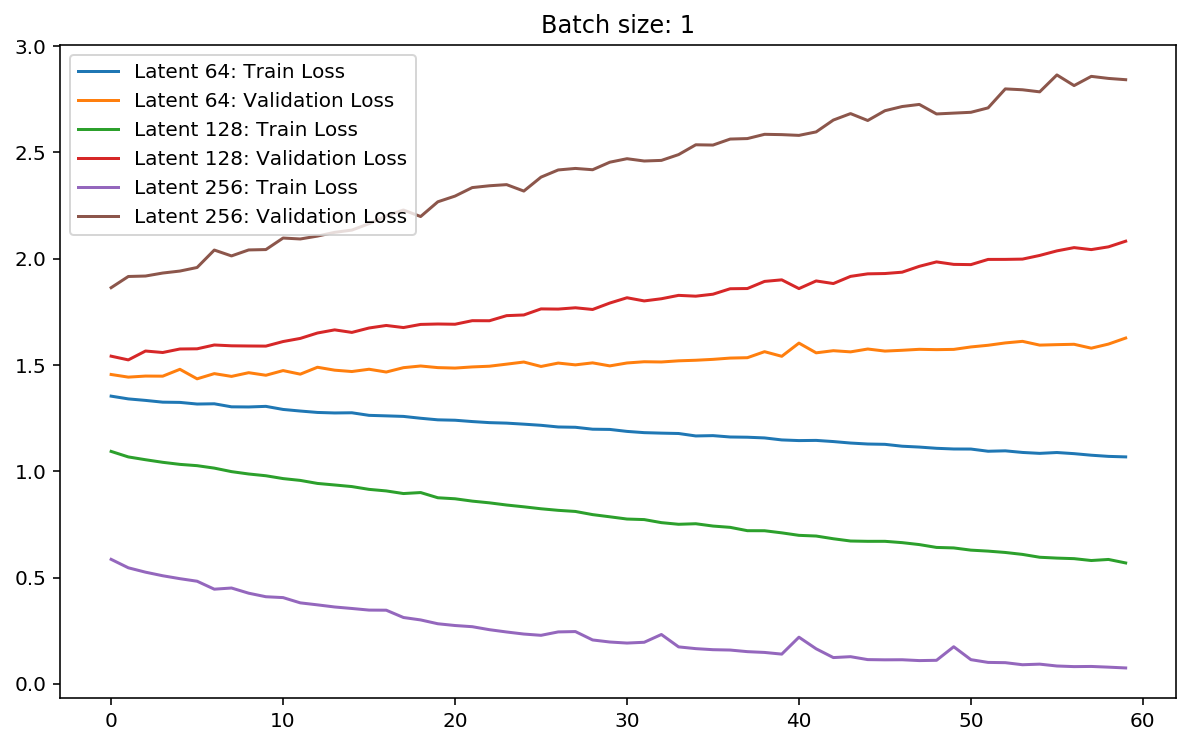

Batch Size: 1 Latent_dim: 256
Batch Size: 8 Latent_dim: 64
Batch Size: 8 Latent_dim: 128


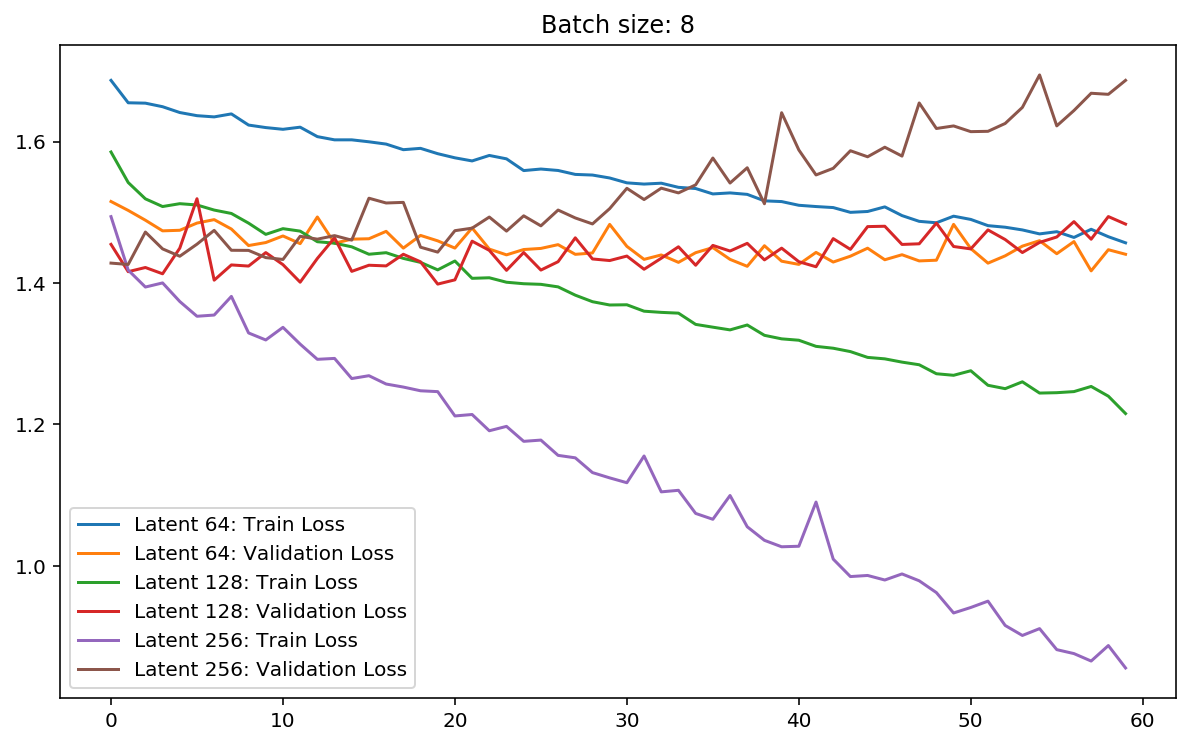

Batch Size: 8 Latent_dim: 256
Batch Size: 16 Latent_dim: 64
Batch Size: 16 Latent_dim: 128


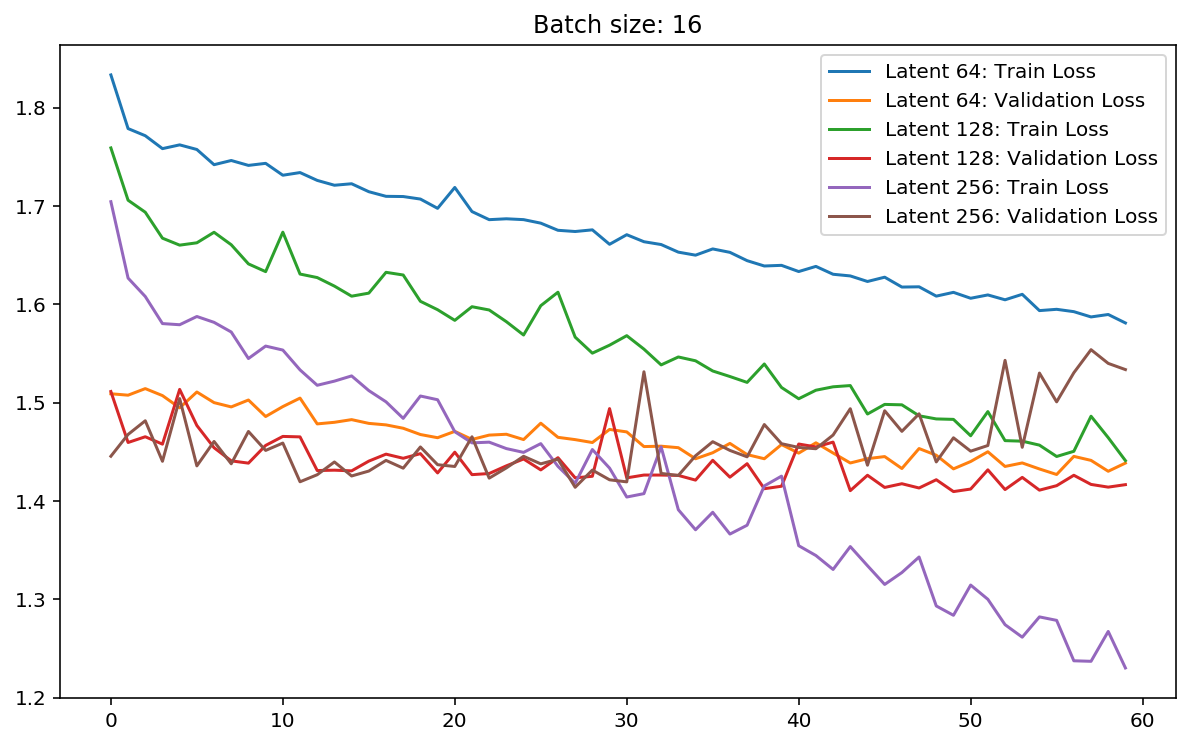

Batch Size: 16 Latent_dim: 256


In [18]:
# This function plot the relationship between training loss and vali loss
import math

def plot_performance(total_history):
    counter_tres = math.sqrt(len(total_history)) - 1
    counter = 0
    plt.rcParams["figure.figsize"] = [10,6]
    for each_config in total_history:
        config = each_config[0]
        train_loss = each_config[1]
        val_loss = each_config[2]
        tot_epoch = each_config[3]
        plt.plot(tot_epoch, train_loss, label="Latent {}: Train Loss".format(str(config[2])))
        plt.plot(tot_epoch, val_loss, label="Latent {}: Validation Loss".format(str(config[2])))
        plt.legend(loc='best')
        if counter >= counter_tres:
            counter = 0
            plt.title("Batch size: {}".format(str(config[0])))
            plt.show()
        else:
            counter += 1
        print("Batch Size: {} Latent_dim: {}".format(str(config[0]), str(config[2])))
plot_performance(total_history)


In [29]:
# modify this latent_dim according to the latent_dim weight you are loading or have trained
latent_dim = 256

# encoder model
encoder_inputs = Input(shape=(None, len(all_keys)))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# Encoder States
encoder_states = [state_h, state_c]

# decoder model
decoder_inputs = Input(shape=(None, len(all_keys)))
decoder = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder(decoder_inputs, initial_state=encoder_states)
# Activation Layer
decoder_dense = Dense(len(all_keys), activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# load the weight you want to test on
model.load_weights("./weights_epoch_120/batch_16_latent_256_.h5")

#########################################################

# encoder model
# used when making a prediction for a new source sequence.
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder model 
# use when making a prediction for a new source sequence.
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

# define model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in key_idx_pair.items())
reverse_target_char_index = dict(
    (i, char) for char, i in key_idx_pair.items())


In [30]:
# The "predict" function
# Given a input melody stream and the first token enlightment
# will return the decoded sequence
def decode_stream(input_stream, first_token):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_stream)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, len(all_keys)))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, key_idx_pair[first_token]] = 1.

    # Sampling loop for a batch of sequences
    stop_condition = False
    decoded_sequence = []
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sequence.append(sampled_char)

        # exit if exceed input stream length
        if (len(decoded_sequence) > max_output_seq_num):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, len(all_keys)))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]
    

    return decoded_sequence

In [31]:
# convert a list of note string to a list of note object
def note_to_midi(seq):
    offset = 0
    output_notes = []

    for i in range(len(seq)):
        pattern = seq[i]
        new_note = None
        # if it's a rest
        if pattern == '*':
            new_note = note.Rest()
            new_note.offset = offset
        # if it's a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
        
        output_notes.append(new_note)
        offset += 0.5

    return output_notes

# The function takes an encoded melody matrix and the original melody note list
# make a left-hand piano stream and gives the option of playing both melody, harmony 
# and the combined part
def generate_music(input_data_matrix, input_data_seq, output_data_seq, idx):
    input_mat = input_data_matrix[idx:idx+1]
    input_seq = input_data_seq[idx]
    output_seq = output_data_seq[idx] # used for retrive the first token for enlightment
    # main melody 
    melody = note_to_midi(input_seq)
    melody = stream.Part(melody)
    # left hand generated by model
    harmony_seq = decode_stream(input_mat, output_seq[0])
    
    all_keys = [] 
    all_freq = []
    for key in harmony_seq:
        if key not in all_keys:
            all_keys.append(key)
            all_freq.append(1)
        else:
            idx = all_keys.index(key)
            all_freq[idx] += 1
    #print(all_freq)

    harmony = note_to_midi(harmony_seq)
    harmony = stream.Part(harmony)
    
    final_score = stream.Score()
    final_score.insert(0, melody)
    final_score.insert(0, harmony)
    
    melody.show('midi')
    #melody.show('text')
    harmony.show('midi')
    #harmony.show("text")
    final_score.show('midi')
    #final_score.show()
    
generate_music(test_encoder_input_data, test_input_streams, test_output_streams, 5)

In [32]:
generate_music(test_encoder_input_data, test_input_streams, test_output_streams, 4)